In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

#그래프 스타일
plt.style.use('ggplot')

import matplotlib as mpl

# 한글 폰트 설정
mpl.rcParams['font.family'] = 'Malgun Gothic'

# 마이너스 깨짐 방지
mpl.rcParams['axes.unicode_minus'] = False

#### 데이터 준비

In [2]:
from sklearn.datasets import load_wine
import pandas as pd

# 데이터셋 로드
wine = load_wine()

# 특징 데이터와 타겟 데이터를 데이터프레임으로 변환
df = pd.DataFrame(data=wine.data, columns=wine.feature_names)
df['target'] = wine.target

# 데이터셋 정보 출력
df.head()


,alcohol,malic_acid,ash,alcalinity_of_ash,magnesium,total_phenols,flavanoids,nonflavanoid_phenols,proanthocyanins,color_intensity,hue,od280/od315_of_diluted_wines,proline,target
0,14.23,1.71,2.43,15.6,127.0,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065.0,0
1,13.20,1.78,2.14,11.2,100.0,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050.0,0
2,13.16,2.36,2.67,18.6,101.0,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185.0,0
3,14.37,1.95,2.50,16.8,113.0,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480.0,0
4,13.24,2.59,2.87,21.0,118.0,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735.0,0


#### 데이터 탐색


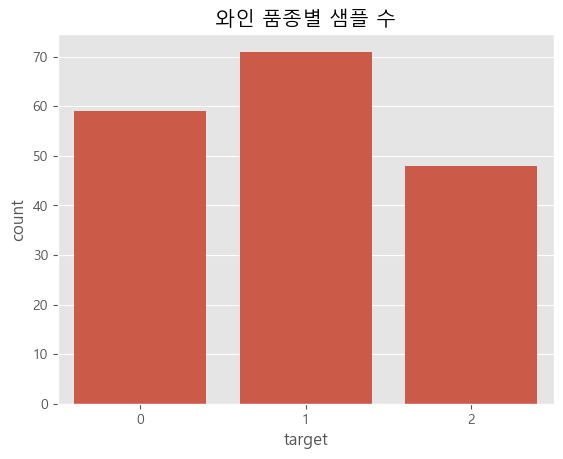

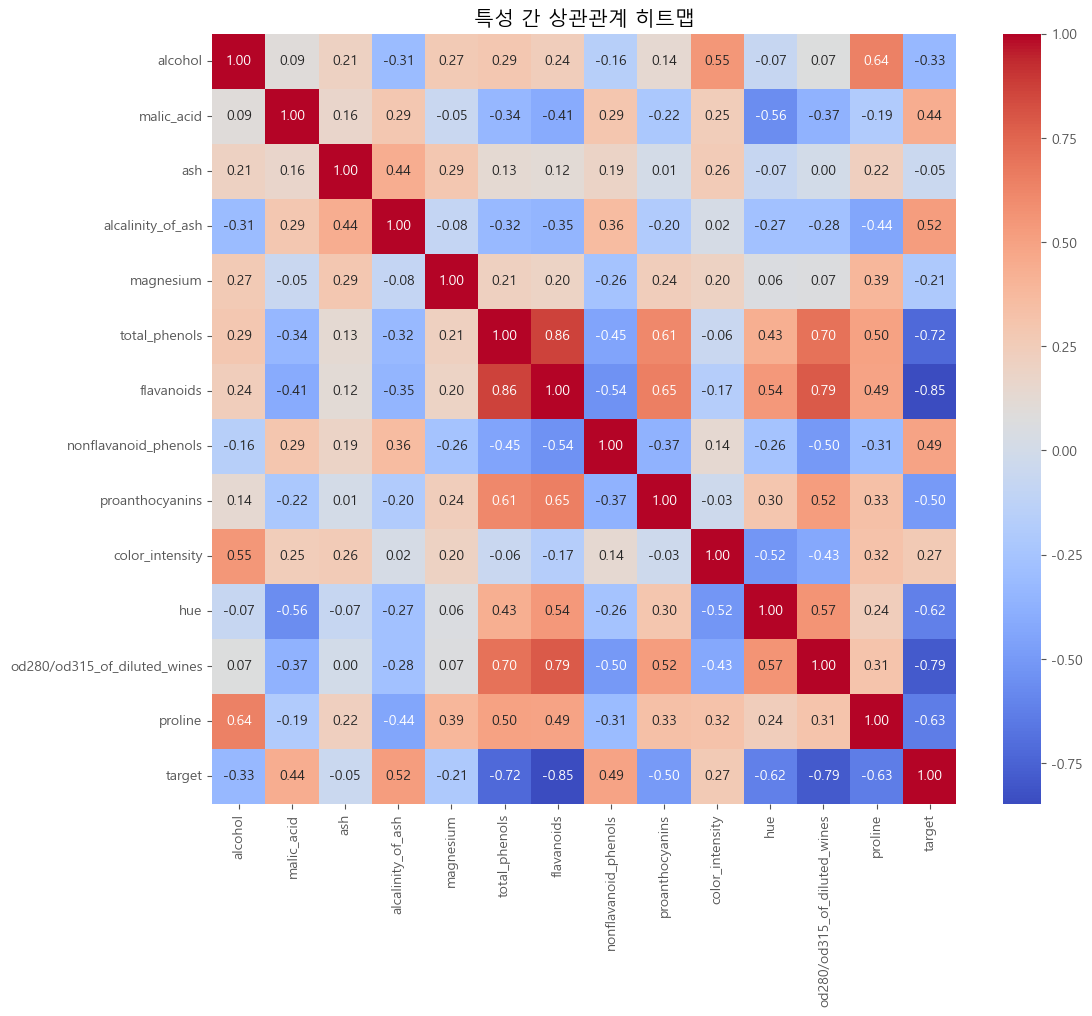

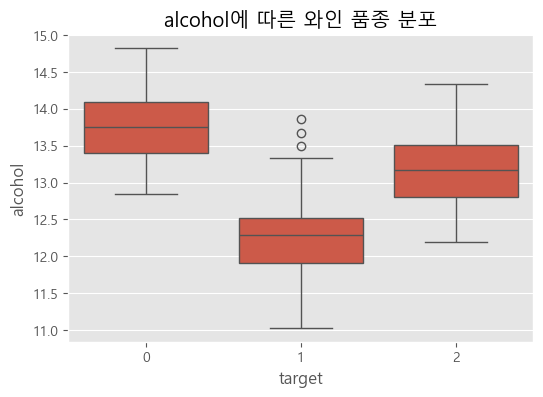

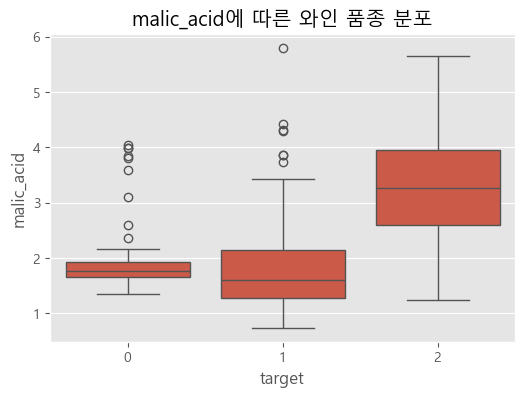

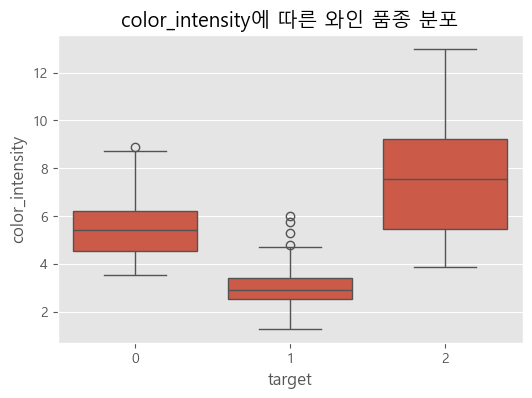

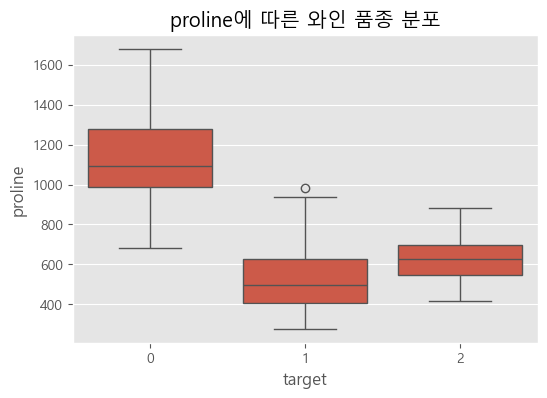

In [12]:
# 타겟 변수 분포
sns.countplot(x='target', data=df)
plt.title('와인 품종별 샘플 수')
plt.show()

# 상관관계 히트맵
plt.figure(figsize=(12, 10))
sns.heatmap(df.corr(), annot=True, fmt=".2f", cmap='coolwarm')
plt.title('특성 간 상관관계 히트맵')
plt.show()

# 주요 변수의 클래스별 분포
selected_cols = ['alcohol', 'malic_acid', 'color_intensity', 'proline']
for col in selected_cols:
    plt.figure(figsize=(6, 4))
    sns.boxplot(x='target', y=col, data=df)
    plt.title(f'{col}에 따른 와인 품종 분포')
    plt.show()

#### 데이터 선택

In [6]:
X = df.drop('target', axis=1)
y = df['target']

#### 훈련/테스트셋 분할

In [7]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

In [8]:
# 표준화

from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

#### 모델 생성 및 훈련

In [9]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV, StratifiedKFold

# 하이퍼파라미터 그리드
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 5, 10],
    'min_samples_split': [2, 4],
    'min_samples_leaf': [1, 2]
}

# 교차검증 전략
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# 모델 + 그리드서치
grid_search = GridSearchCV(
    estimator=RandomForestClassifier(random_state=42),
    param_grid=param_grid,
    cv=cv,
    n_jobs=-1,
    scoring='accuracy',
    verbose=1
)

grid_search.fit(X_train_scaled, y_train)

Fitting 5 folds for each of 36 candidates, totalling 180 fits


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
             estimator=RandomForestClassifier(random_state=42), n_jobs=-1,
             param_grid={'max_depth': [None, 5, 10], 'min_samples_leaf': [1, 2],
                         'min_samples_split': [2, 4],
                         'n_estimators': [50, 100, 200]},
             scoring='accuracy', verbose=1)

In [10]:
print("최적 하이퍼파라미터:", grid_search.best_params_)
print("훈련셋 교차검증 최고 정확도:", grid_search.best_score_)

최적 하이퍼파라미터: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
훈련셋 교차검증 최고 정확도: 0.9790640394088669


#### 예측 및 평가

테스트셋 정확도: 1.0

분류 리포트:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00        12
           1       1.00      1.00      1.00        14
           2       1.00      1.00      1.00        10

    accuracy                           1.00        36
   macro avg       1.00      1.00      1.00        36
weighted avg       1.00      1.00      1.00        36



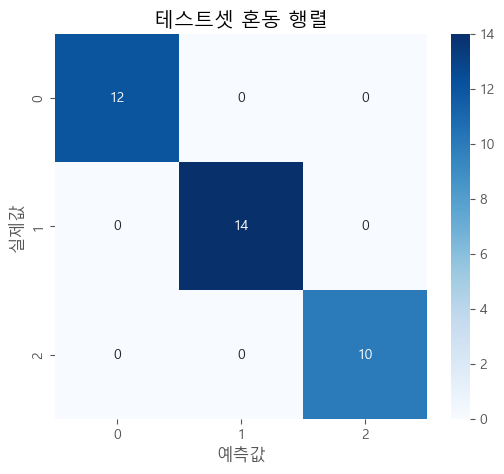

In [11]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test_scaled)

print("테스트셋 정확도:", accuracy_score(y_test, y_pred))
print("\n분류 리포트:\n", classification_report(y_test, y_pred))

# 혼동 행렬
plt.figure(figsize=(6, 5))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues')
plt.title("테스트셋 혼동 행렬")
plt.xlabel("예측값")
plt.ylabel("실제값")
plt.show()